# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

In [37]:
# Load the datasets
train = pd.read_csv('/Users/macbook/Library/CloudStorage/GoogleDrive-s.mwachoni@alustudent.com/My Drive/Kaggle_competition_ML/air_quality_forecasting/train.csv', parse_dates=['datetime'])
test = pd.read_csv('/Users/macbook/Library/CloudStorage/GoogleDrive-s.mwachoni@alustudent.com/My Drive/Kaggle_competition_ML/air_quality_forecasting/test.csv', parse_dates=['datetime'])

# Sort by datetime
train = train.sort_values('datetime')
test = test.sort_values('datetime')

# Set datetime as index
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [18]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


# VISUALIZATIONS

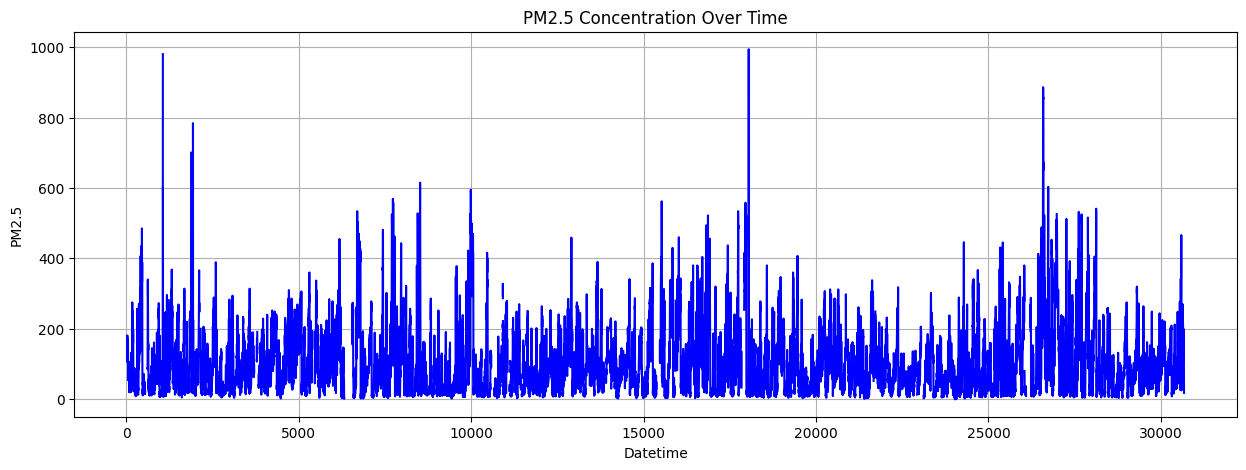

In [19]:
# Time Series Plot for PM2.5 Over Time
plt.figure(figsize=(15,5))
plt.plot(train['pm2.5'], color='blue')
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()


Time Series Plot Interpretation:-
1. The plot shows that the PM2.5 concentration fluctuates a lot over time, seen from the peaks and troughs, which is caused by clear periodic patterns.
2. The plot confirms that PM2.5 levels are hihgly variable over time hence the appropriateness of time aware models for the prediction such as LSTMs.


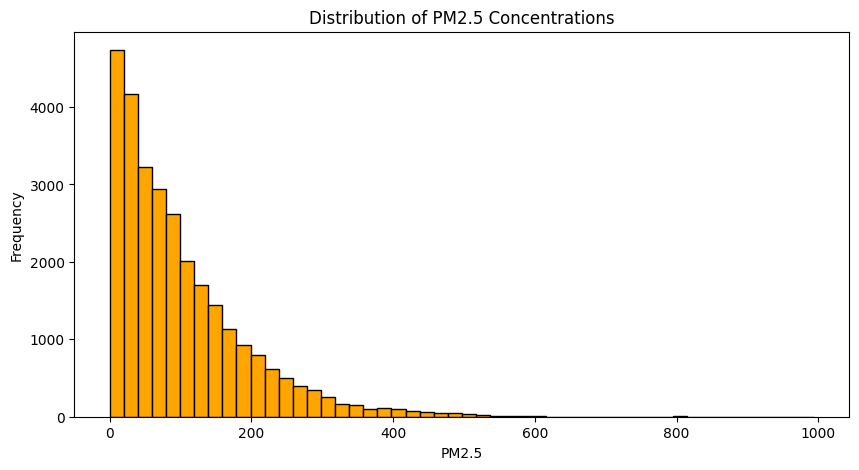

In [20]:
#Histogram of PM2.5 Concentrations
plt.figure(figsize=(10,5))
plt.hist(train['pm2.5'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of PM2.5 Concentrations')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()


Histogram Plot Interpretation:-
1. From the plot, the data is right-skewed, meaning high pollution events are rare but may be extreme.
2. Air quality is within moderate pollution ranges majority of the time.
3. The distribution suggests that the model needs to be sensitive to both common conditions and rare spikes.

In [39]:
def create_features(df, is_train=True, train_ref=None):
    df = df.copy()
    
    # Time features
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    
    # Cyclic encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    
    # Meteorological features
    df['temp_dew_diff'] = df['TEMP'] - df['DEWP']
    df['pressure_norm'] = (df['PRES'] - 1000) / 50
    
    # Lag features (critical for LSTM)
    lags = [1, 2, 3, 6, 12, 24, 24*3, 24*7]
    for lag in lags:
        if is_train:
            df[f'pm2.5_lag_{lag}'] = df['pm2.5'].shift(lag)
        else:
            # For test set, use values from train_ref
            df[f'pm2.5_lag_{lag}'] = train_ref['pm2.5'].shift(lag).iloc[-1]
    
    # Rolling statistics (only for training)
    if is_train:
        windows = [3, 6, 12, 24]
        for w in windows:
            df[f'pm2.5_rollmean_{w}'] = df['pm2.5'].rolling(w).mean()
            df[f'pm2.5_rollstd_{w}'] = df['pm2.5'].rolling(w).std()
    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

# Apply feature engineering
train_fe = create_features(train, is_train=True)
test_fe = create_features(test, is_train=False, train_ref=train)

/var/folders/83/b3hg3w3149d0ggjkhcq298fw0000gn/T/ipykernel_6097/958622238.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/83/b3hg3w3149d0ggjkhcq298fw0000gn/T/ipykernel_6097/958622238.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/var/folders/83/b3hg3w3149d0ggjkhcq298fw0000gn/T/ipykernel_6097/958622238.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/83/b3hg3w3149d0ggjkhcq298fw0000gn/T/ipykernel_6097/958622238.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.f

In [40]:
# Feature selection
features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
           'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
           'temp_dew_diff', 'pressure_norm'] + \
          [f'pm2.5_lag_{lag}' for lag in [1, 2, 3, 6, 12, 24, 24*3, 24*7]] + \
          [f'pm2.5_rollmean_{w}' for w in [3, 6, 12, 24]] + \
          [f'pm2.5_rollstd_{w}' for w in [3, 6, 12, 24]]

# Scaling
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_train = scaler_X.fit_transform(train_fe[features])
y_train = scaler_y.fit_transform(train_fe[['pm2.5']])

# Save scalers
joblib.dump(scaler_X, 'scaler_X.joblib')
joblib.dump(scaler_y, 'scaler_y.joblib')

# Sequence generator
def create_sequences(X, y, window_size=24, horizon=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - horizon + 1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size+horizon-1])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_train, y_train)

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [41]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_lstm_model((X_seq.shape[1], X_seq.shape[2]))

In [ ]:
# Time-series cross validation
tss = TimeSeriesSplit(n_splits=3)
best_models = []

for fold, (train_idx, val_idx) in enumerate(tss.split(X_seq)):
    print(f"\nFold {fold+1}")
    X_train_fold, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train_fold, y_val = y_seq[train_idx], y_seq[val_idx]
    
    model = build_lstm_model((X_seq.shape[1], X_seq.shape[2]))
    
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )
    best_models.append(model)

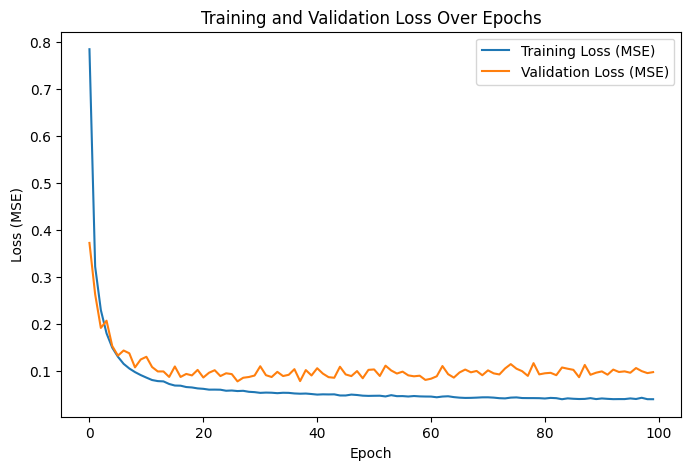

766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
Final Training RMSE (original scale): 26.7600


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Plot training loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# 2. Compute and print final training RMSE in original scale
y_train_pred_scaled = model.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_true = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

final_train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
print(f"Final Training RMSE (original scale): {final_train_rmse:.4f}")


In [ ]:
# Load scalers
scaler_X = joblib.load('scaler_X.joblib')
scaler_y = joblib.load('scaler_y.joblib')

# Prepare test data
X_test = scaler_X.transform(test_fe[features])

# Ensemble predictions from all folds
all_preds = []
for model in best_models:
    preds = []
    last_window = X_train[-24:]  # Last window from training
    
    for i in range(len(X_test)):
        # Predict next step
        pred = model.predict(last_window.reshape(1, 24, -1), verbose=0)
        preds.append(pred[0,0])
        
        # Update window
        new_row = X_test[i].copy()
        new_row[0] = pred  # Update pm2.5 with prediction
        last_window = np.vstack([last_window[1:], new_row])
    
    all_preds.append(preds)

# Average predictions
predictions = np.mean(all_preds, axis=0)
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Post-processing
predictions = np.clip(predictions, 0, None)  # Ensure non-negative
predictions = pd.Series(predictions).rolling(3, center=True, min_periods=1).mean().values

In [ ]:
import os
# Submission
row_ids = pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S')
submission = pd.DataFrame({'row ID': row_ids, 'pm2.5': predictions})

# Validation checks
assert submission.shape[0] == 13148, f"Expected 13148 rows, got {submission.shape[0]}"
assert not submission.isna().any().any(), "NaN values in submission"
assert (submission['pm2.5'] >= 0).all(), "Negative predictions found"

print(f"Prediction stats - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}, Mean: {predictions.mean():.1f}")

# Save Submission 
output_dir = '/Users/macbook/Library/CloudStorage/GoogleDrive-s.mwachoni@alustudent.com/My Drive/Kaggle_competition_ML/air_quality_forecasting'
submission_name = f'submission_{pd.Timestamp.now().strftime("%Y%m%d_%H%M")}.csv'
submission_path = os.path.join(output_dir, submission_name)

submission.to_csv(submission_path, index=False)
print(f"Submission saved to: {submission_path}")

 17/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

/var/folders/83/b3hg3w3149d0ggjkhcq298fw0000gn/T/ipykernel_6097/920847794.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_lagged = test_lagged.fillna(method='ffill').fillna(method='bfill')


411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Prediction stats - Min: 0.0, Max: 0.0, Mean: 0.0
Submission saved to: /Users/macbook/Library/CloudStorage/GoogleDrive-s.mwachoni@alustudent.com/My Drive/Kaggle_competition_ML/air_quality_forecasting/submission_20250527_1934.csv
